In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# torch.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset Preprocessing

Split data into train, validation and test:  
80% train, 10% validation, 10% test:

Years selected for test and validation (based of random number generation):
Valid and test years pairs are selected within one year of seperation
valid = 2022, 1999, 2008, 1990
test = 2023,  1998, 2009, 1991

Validation years

In [14]:
datafolder = "./data/"
merge_df = pd.DataFrame()
for i, file in enumerate(os.listdir(datafolder)):
    if i == 0:
        merge_df = pd.read_csv(datafolder + file)
    else:
        df = pd.read_csv(datafolder + file)
        merge_df = pd.merge(merge_df, df, on="month")
    
#Set 
merge_df["month_num"] = merge_df["month"].apply(lambda x: int(x.split("-")[1]))

merge_df['month'] = pd.to_datetime(merge_df['month'], format='%Y-%m').dt.to_period('M')
merge_df.set_index('month', inplace=True)



group_2 = ['2022', '1999', '2008', '1990']
group_3 = ['2023', '2009', '1998', '1991']

# Filter DataFrames by year
valid_df = merge_df[merge_df.index.year.astype(str).isin(group_2)]
test_df = merge_df[merge_df.index.year.astype(str).isin(group_3)]
train_df = merge_df[~merge_df.index.year.astype(str).isin(group_2 + group_3)]

In [15]:
scaler = MinMaxScaler()

train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
valid_df_scaled = pd.DataFrame(scaler.transform(valid_df), columns=valid_df.columns, index=valid_df.index)
test_df_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

# RNN

In [16]:
input_size = len(train_df.columns)
seq_len = 12
batch_size = 32
hidden_size = 50
output_size = 1
num_layers = 4

num_epochs = 1000
learning_rate = 0.001

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.inputs = []
        self.outputs = []

        if len(df) >= seq_len + output_size:
            for i in range(seq_len, len(df) - output_size + 1):
                self.inputs.append(df.iloc[i - seq_len:i].values)
                self.outputs.append(df.iloc[i:i + output_size]["total_rainfall"].values)
        else:
            raise ValueError(f"DataFrame length ({len(df)}) is too short for the given seq_len ({seq_len}) and output_size ({output_size}).")

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.outputs[index]
    
# train = CustomDataset(normalised_train_df)
# valid = CustomDataset(normalised_valid_df)
# test = CustomDataset(normalised_test_df)

train_data = CustomDataset(train_df_scaled)
valid_data = CustomDataset(valid_df_scaled)
test_data = CustomDataset(test_df_scaled)


train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [17]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _= self.rnn(x)
        out = self.fc(out)
        return out.squeeze()
    
rnn_model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)

def train(model, train_dataloader, valid_dataloader, num_epochs, learning_rate):
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_total_loss, valid_total_loss = [], []
    for epoch in range(num_epochs):
        train_loss_sum, valid_loss_sum = 0, 0
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            train_loss_sum += loss
            optimizer.step()
        
        if epoch%100 == 0:    
            train_total_loss.append(train_loss_sum/len(train_dataloader))
            with torch.no_grad():
                for inputs, targets in valid_dataloader:
                    inputs = inputs.to(device).float()
                    targets = targets.to(device).float()
                    outputs = model(inputs)
                    valid_loss = criterion(outputs, targets)
                    valid_loss_sum += valid_loss
            valid_total_loss.append(valid_loss/len(valid_dataloader))

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_sum / len(train_dataloader)}, Valid Loss: {valid_loss_sum / len(valid_dataloader)}")

            torch.save(model.state_dict(), f"models/rnn-{epoch}.pth")



    print("Training complete!")

    return model, train_total_loss, valid_total_loss

rnn_model, train_total_loss, valid_total_loss = train(rnn_model, train_dataloader, valid_dataloader, num_epochs, learning_rate)

torch.save(rnn_model.state_dict(), "rnn_model.pt")

C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

Epoch 1/1000, Train Loss: 0.04951150715351105, Valid Loss: 0.023494668304920197
Epoch 101/1000, Train Loss: 0.022003093734383583, Valid Loss: 0.00934080220758915
Epoch 201/1000, Train Loss: 0.01387050561606884, Valid Loss: 0.016937855631113052
Epoch 301/1000, Train Loss: 0.007142853923141956, Valid Loss: 0.0410257950425148
Epoch 401/1000, Train Loss: 0.0049174572341144085, Valid Loss: 0.020278386771678925
Epoch 501/1000, Train Loss: 0.003697446081787348, Valid Loss: 0.016316650435328484
Epoch 601/1000, Train Loss: 0.0029800746124237776, Valid Loss: 0.04855400696396828
Epoch 701/1000, Train Loss: 0.0024627072270959616, Valid Loss: 0.02685306966304779
Epoch 801/1000, Train Loss: 0.002240432659164071, Valid Loss: 0.019416140392422676
Epoch 901/1000, Train Loss: 0.0016576221678406, Valid Loss: 0.019175490364432335
Training complete!


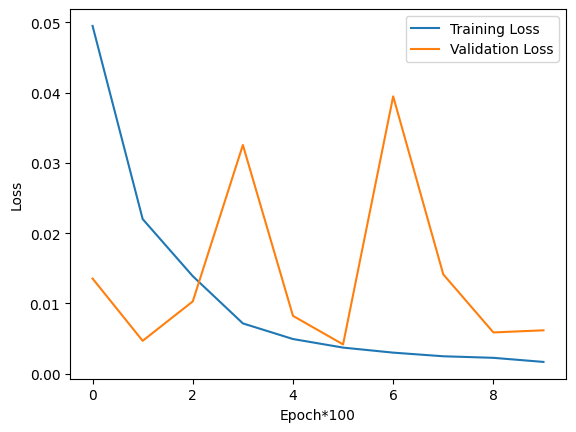

In [19]:
#plot training/validation loss curve

# Detach tensors and convert to numpy for plotting
train_total_loss_np = [loss.detach().numpy() for loss in train_total_loss]
valid_total_loss_np = [loss.detach().numpy() for loss in valid_total_loss]

plt.plot(train_total_loss_np, label='Training Loss')
plt.plot(valid_total_loss_np, label='Validation Loss')
plt.xlabel('Epoch*100')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss
    return total_loss


train_loss = evaluate(rnn_model, train_dataloader)
valid_loss = evaluate(rnn_model, valid_dataloader)
test_loss = evaluate(rnn_model, test_dataloader)

print(f"Train Loss: {train_loss}")
print(f"Valid Loss: {valid_loss}")
print(f"Test Loss: {test_loss}")


Train Loss: 0.017626935616135597
Valid Loss: 0.07804854959249496
Test Loss: 0.047851551324129105


C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\loype\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

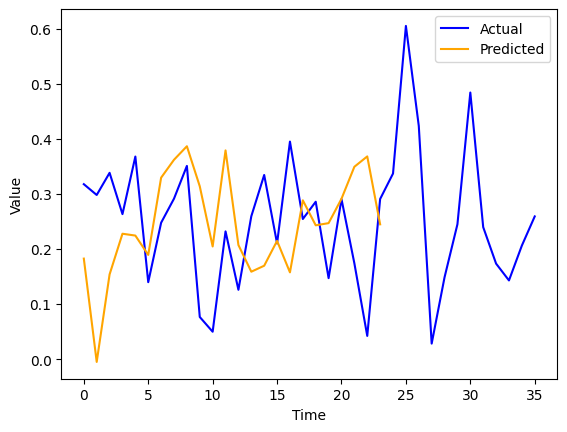

In [27]:
# plot actual vs predicted

def plot_actual_vs_predicted(model, dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device).float()
            targets = targets[:, -1].to(device).float()
            outputs = model(inputs)
            actual.extend(targets.cpu().numpy())
            predicted.extend(outputs.cpu().numpy()[0])
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predicted, label='Predicted', color='orange')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return actual, predicted

actual, predicted = plot_actual_vs_predicted(rnn_model, test_dataloader)